In [326]:
# !pip install --upgrade boto3

In [327]:
import boto3
import json

import uuid 
#import re

from io import BytesIO

from IPython.display import display
from PIL import ImageDraw, Image

from trp import Document
from a2irp import A2IDocument

#create a S3 Client
s3 = boto3.client('s3')
#create a Textract Client
textract = boto3.client('textract')
#create a A2I Runtime Client
a2i_runtime_client = boto3.client('sagemaker-a2i-runtime')

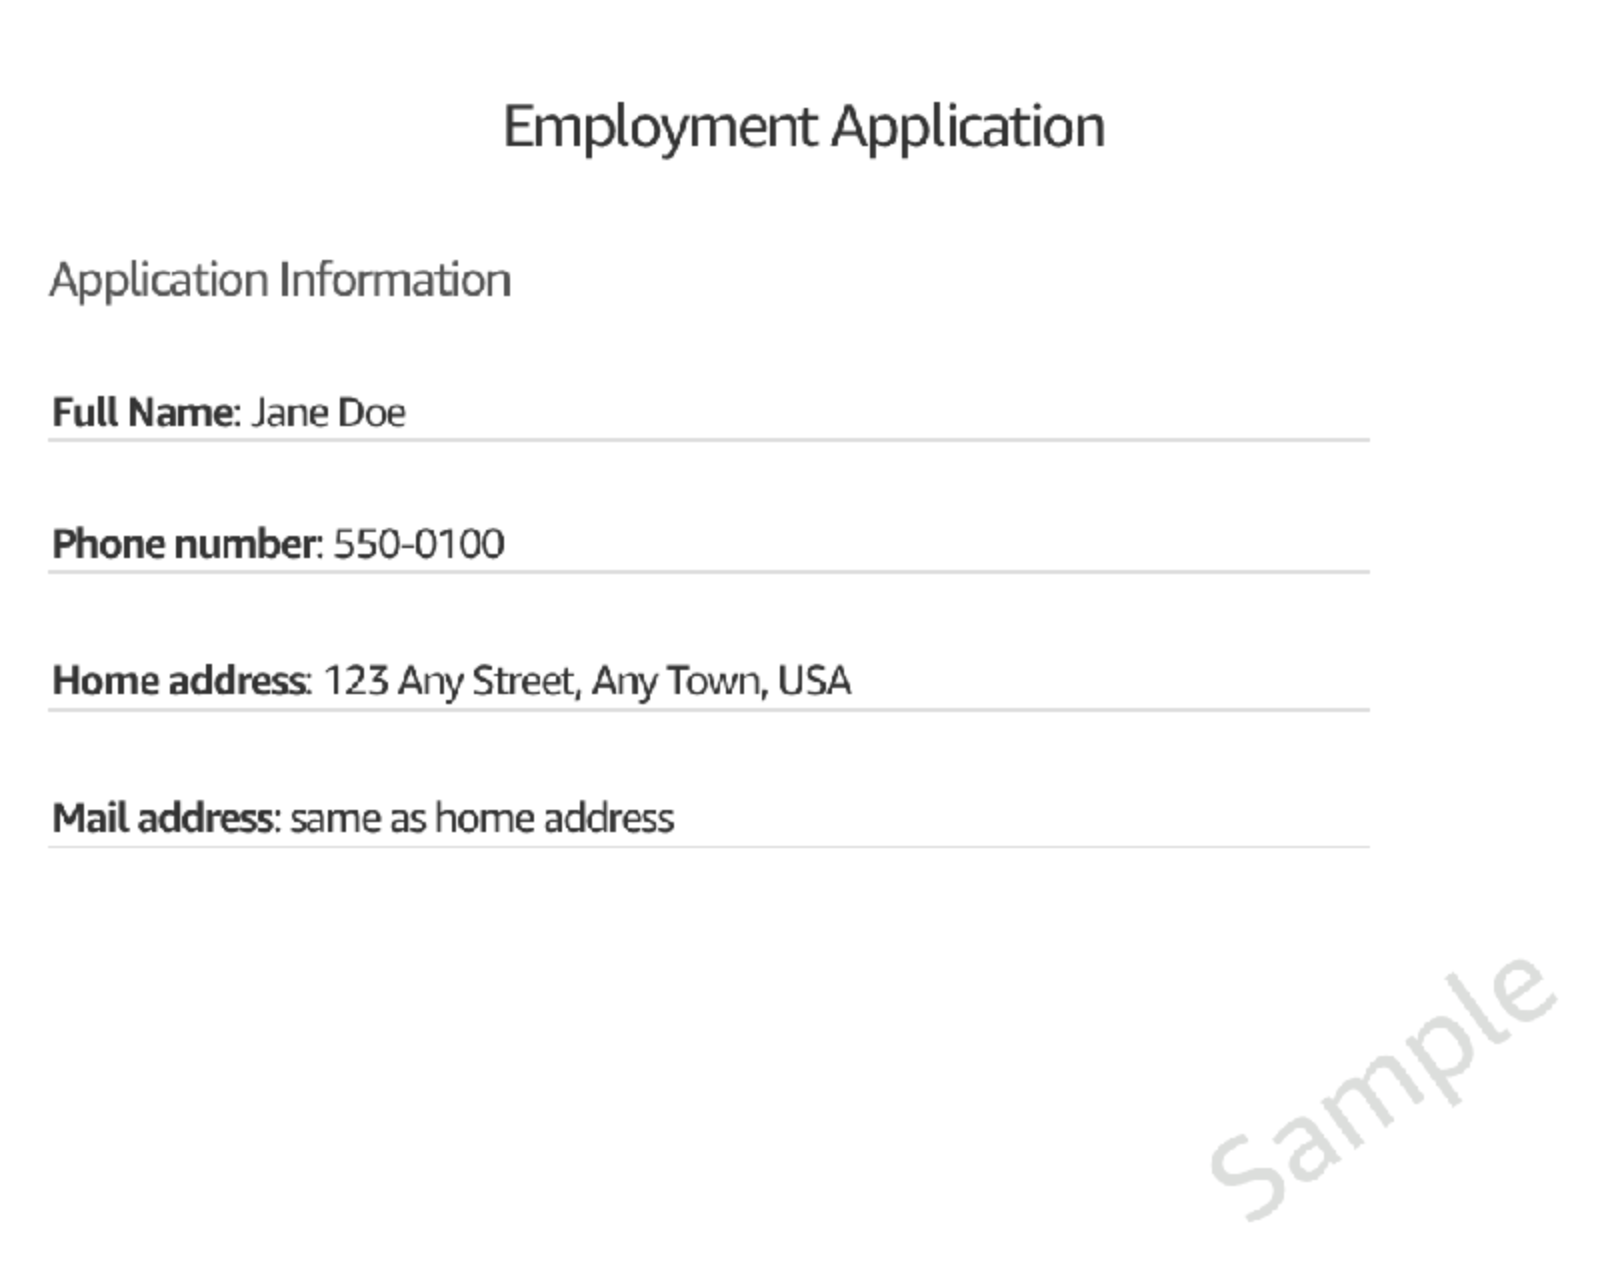

In [328]:
#Set File location
bucket_name = "aimlresources"
document_name = "textract/docs/FormDemo.png"

#Create a S3 file object using the bucket and object key. 
fileobj = s3.get_object(
    Bucket=bucket_name,
    Key=document_name
    ) 

# open the S3 file object and read it into the variable filedata. 
filedata = fileobj['Body'].read()

#For a PDF example
img = Image.open(BytesIO(filedata)) 

display(img) 

In [329]:
# Analyze the PNG Page using A2I Human in the loop
human_loop_name = str(uuid.uuid4())
flow_definition_arn = 'enter your ARN'

response = textract.analyze_document(
    Document={'S3Object': {'Bucket': bucket_name,'Name': document_name }}, 
    FeatureTypes=['FORMS'], 
    HumanLoopConfig={'HumanLoopName': human_loop_name, 
                     'FlowDefinitionArn': flow_definition_arn}
    )


In [330]:
doc = Document(response)
page = doc.pages[0]

In [333]:
a2i_bucket = 'aimlresources'
all_human_loops_in_workflow = a2i_runtime_client.list_human_loops(FlowDefinitionArn=flow_definition_arn)['HumanLoopSummaries']

for human_loop in all_human_loops_in_workflow:
    
    print(f'\nHuman Loop Name: {human_loop["HumanLoopName"]}')
    print(f'Human Loop Status: {human_loop["HumanLoopStatus"]}')
    
    if human_loop['HumanLoopStatus'] == 'Completed':
        
        describe_human_loop_response = a2i_runtime_client.describe_human_loop(HumanLoopName=human_loop['HumanLoopName'])
        a2i_s3_output_uri = describe_human_loop_response["HumanLoopOutput"]["OutputS3Uri"]
        print(f'Human Loop Output Location: : {a2i_s3_output_uri} \n')
    
        splitted_string = re.split('s3://' +  a2i_bucket + '/', a2i_s3_output_uri)
        a2i_key = splitted_string[1]        
        fileobj = s3.get_object(Bucket=a2i_bucket,Key=a2i_key)         
        a2i_response = A2IDocument(json.loads(fileobj["Body"].read()))
        
        for field in page.form.fields:
            a2i_field_value = a2i_response.get_field_by_key(field.key)
            if (a2i_field_value):
                print("{}".format(field.key))
                print("Original Value:{}".format(field.value))
                print("Reviewed Value:{}\n".format(a2i_field_value))


Human Loop Name: 7a2b5440-0e99-4985-a5ff-665857d73736
Human Loop Status: Completed
Human Loop Output Location: : s3://aimlresources/a2i/outputs/octa-forms-review-workflows/2021/03/04/01/20/20/7a2b5440-0e99-4985-a5ff-665857d73736/output.json 

Full Name:
Original Value:Jane Doe
Reviewed Value:Jean Dome

Home address:
Original Value:123 Any Street, Any Town, USA
Reviewed Value:123 14th Street, Seattle, WA USA

Phone number:
Original Value:550-0100
Reviewed Value:55508100

Mail address:
Original Value:same as home address
Reviewed Value:same as home address


Human Loop Name: 40c1ba7d-73ed-4494-9a1f-25a2c8de6c18
Human Loop Status: Completed
Human Loop Output Location: : s3://aimlresources/a2i/outputs/octa-forms-review-workflows/2021/03/03/22/43/36/40c1ba7d-73ed-4494-9a1f-25a2c8de6c18/output.json 

Full Name:
Original Value:Jane Doe
Reviewed Value:John Wake

Home address:
Original Value:123 Any Street, Any Town, USA
Reviewed Value:123 Any Street, Any Town, USA

Phone number:
Original Valu